# Business Problem

## Business Situation

All in One Co. is a multibrand outlet that wants to create a loyality program the best customers called INSIDERS. The company has registered one year of purchasing from its customers and wants to reward those customers with marketing actions. 

Business Questions:
- Who are the customers elegible?
- How many customers will be part of Insiders group?
- What are the main behaviour of those customers?
- How much revenue comes from Insiders customer groups?
- How much revenue is expected from Insiders next month?
- Which conditions one person must comply to be an Insider?
- What removes a customer from Insider group?
- What guarantees the loyality program customers are better than others?
- Which actions MKT team could take to increase revenue?

## Business Understanding & Solution Planning

A) <u>Business problem (open question)</u> - **How could we identify customers to a loyality program?**

B) <u>Business understanding</u>

- **Motivation?** The company wants to identify the most valuable customers in order to promote a loyality program and increase engagement/purchasing from those customers. MKT team wants to address some initiatives to increase revenue from this valuable group. Thus, was requested to Data team to evaluate current purchasing data  and propose tools to help the company build the Insiders program. 

- **Root cause**: Increase revenue

- **Scope**: (closed affirmation): 
  - Firstly: Build a tool to help identify most valuable customers from actual (one year) purchasing database
  - Secondarily: Build a report to answer some business questions and support MKT initiatives. 
  
    
- **Stakeholder**? CFO


- **Acceptance Criteria**: ??

### Planning Solution

**Solution overview**:

 - <u>Kind of problem</u>: Most valuable customers identification in order to frame into loyality program
 - <u>Potential methods</u>: Clustering

#### Inputs

- Business Problem, i.e, identify most valuable customers in order to create a new loyality program and increase revenue through marketing actions
- Products sales data from Nov 2015 to Dec 2017
- Tools: 
    - Python
    - Jupyter Nb
    - Pandas, Seaborn, Sklearn, etc

#### Outputs

- Provide a list of customers that will be part of Insiders Loyality Program:


    - List format:
            client_id | is_insider:
            234213213 | no  / 0
            324325252 | yes / 1
            435345353 | yes / 1
            
            
- Report answering business questions:


    - 1. Who are the customers elegible?
    - 2. How many customers will be part of Insiders group?
    - 3. What are the main behaviour of those customers?
    - 4. How much revenue comes from Insiders customer groups?
    - 5. How much revenue is expected from Insiders next month?
    - 6. Which conditions one person must comply to be an Insider?
    - 7. What removes a customer from Insider group?
    - 8. What guarantees the loyality program customers are better than others?
    - 9. Which actions MKT team could take to increase revenue?

#### Tasks

- 1. Who are the customers elegible?

    - Who is most valuable customers? => Must be evaluated with business experts
        - Revenue:
            - High ticket?
            - High LTV?
            - High frequency?
            - High basket size?
            - Low churn?
        - Cost:
            - Low return rate?
            - Low CAC?
            
        - Experience:
            - High xp evaluation?
            
- 2. How many customers will be part of Insiders group?
        - Total of customers
        - % Insiders
        
- 3. What are the main behaviour of those customers?
        - Stratify customers characteristics and consumptions habits -> clustering features
        
- 4. How much revenue comes from Insiders customer groups?
        - Total revenue
        - Revenue from insiders
        
- 5. How much revenue is expected from Insiders next month?
        - LTV Insiders group
        - Cohort analysis (time, product, etc) 
        
- 6. Which conditions one person must comply to be an Insider?
        - Person must obbey clustering parameters
        - Retrain clustering to identify (1, 3 months)


- 7. What removes a customer from Insider group?
        - Persons that don't follow clustering parameters will be excluded
        - Retrain clustering to identify (1, 3 months)

- 8. What guarantees the loyality program customers are better than others?
        - A/B testing

- 9. Which actions MKT team could take to increase revenue?
        - Special offers, purchasing preference, free shipment, etc
        


#### Solution Benchmarks 

**Desk Research**
- RFM model (Recency, Frequency, Monetary) => MVP
    - Step1: Pick one scope and order customers
    - Step2: Split and rank (R-Score, F-Score, M-Score) the customers according to levels (ex: Lvl 1-5, 20% of customer in each level)
    - Step3: Calculate mean from R-Score, F-Score, M-Score and order
    - See RFM Segmentation and strategies to engage customers

## Project Assumptions

- invoice_no with letter 'C' will be considered returned goods
- Text in stock_code will be dropped
- Prices below 0.04 will considered as error
- Records with empty customer_id will be filled by new generated customer_ids

## Others

C) Insights


D) Business Results


E) Conclusion (Objectives reached? Problems faced?)


F) Next Steps

G) Lessons learned

# 0. Imports

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import inflection
import re
import umap.umap_ as umap
import warnings
import optuna
from matplotlib import pyplot as plt
from matplotlib import cm
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from scipy.cluster import hierarchy
from sklearn.ensemble import RandomForestRegressor
from plotly import express as px
from pandas_profiling import ProfileReport

SEED = 42

## 0.1 Helper Functions

In [3]:
from IPython.display import display, HTML, Image
warnings.filterwarnings('ignore')
display(HTML("<style>.container { width:100% !important; }</style>"))

%matplotlib inline

def outlier_detection(data, column):
    
    q1 = np.percentile(data[column], 25)
    q3 = np.percentile(data[column], 75)
    
    iqr = q3 - q1

    lo_lim = q1 - 1.5*iqr
    up_lim = q3 + 1.5*iqr
    
    outliers = [x for x in data[column] if (x > up_lim) | (x<lo_lim)]
    
    return sorted(outliers)

def plot_sillhouete_n_clusters(data, model_param, model_name, list_n_clusters):

    fig,ax = plt.subplots(int(len(list_n_clusters)/2), 2)
    fig.set_size_inches(15,15)
    
    for k in list_n_clusters:
        
        q, mod = divmod(k,2)
        
        # Perform clustering
        model = model_param(n_clusters=k).fit(data)

        # Compute the silhouette scores for each sample
        silhouette_vals = metrics.silhouette_samples(data, model.labels_)

        # Create a subplot for each cluster
        y_lower = 10

        for i in range(k):
            
            # Aggregate the silhouette scores for samples in the current cluster
            ith_cluster_silhouette_vals = silhouette_vals[model.labels_ == i]
            ith_cluster_silhouette_vals.sort()

            # Size of the current cluster
            size_cluster_i = ith_cluster_silhouette_vals.shape[0]
            y_upper = y_lower + size_cluster_i

            # Color for the current cluster
            color = cm.nipy_spectral(float(i) / k)

            # Plot the silhouette scores for the current cluster
            ax[q-1,mod].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_vals,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers
            ax[q-1,mod].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10
            
             # Set the limits, labels and title of the silhouette plot
            ax[q-1,mod].set_xlim([-0.2, 1])
            ax[q-1,mod].set_ylim([0, len(data) + (k + 1) * 10])
            ax[q-1,mod].set_xlabel("Silhouette score")
            ax[q-1,mod].set_ylabel("Cluster label")
            ax[q-1,mod].set_title("Silhouette analysis for {} clustering with {} clusters".format(model_name, k))

## 0.2 Loading Data

In [4]:
#load data
df_raw = pd.read_csv('../data/raw/Ecommerce.csv', encoding = "ISO-8859-1")
#drop undesired column
df_raw = df_raw.drop(columns='Unnamed: 8')

In [5]:
df_raw

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,7-Dec-17,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,7-Dec-17,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,7-Dec-17,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,7-Dec-17,4.15,12680.0,France


# 1. Data Description

In [6]:
df1 = df_raw.copy()

## 1.0 Rename Columns

In [7]:
#transforming to columns to snake_case 
new_cols=[]

for col in df1.columns:
    new_cols.append(inflection.underscore(col))  
    
df1.columns = new_cols 

## 1.1 Data Dimensions

In [8]:
print('The dataset has {} rows'.format(df1.shape[0]))
print('The dataset has {} attributes'.format(df1.shape[1]))

The dataset has 541909 rows
The dataset has 8 attributes


Ok, Pandas is capable to deal with this data volume

## 1.2 Check NAs

In [9]:
df1.isna().sum()*100 / df1.shape[0]

invoice_no       0.000000
stock_code       0.000000
description      0.268311
quantity         0.000000
invoice_date     0.000000
unit_price       0.000000
customer_id     24.926694
country          0.000000
dtype: float64

### 1.2.1 Adjust NAs

In [10]:
#customer_id missing values will be replaced by sequential generated id
df1['customer_id'].max()

18287.0

In [11]:
#getting unique invoice_no to missing customer_id 
df_missing = df1[df1['customer_id'].isna()].drop_duplicates(subset='invoice_no')

#setting new customer_id's
df_missing['new_customer_id'] = np.arange(19000, 19000+len(df_missing),1)

#combining back new ids
df1 = pd.merge(df1, df_missing[['invoice_no','new_customer_id']], on='invoice_no', how='left')
df1['customer_id'] = df1['customer_id'].combine_first(df1['new_customer_id'])

#dropping derived column
df1 = df1.drop(columns='new_customer_id')

In [12]:
df1.isna().sum() *100  / df1.shape[0]

invoice_no      0.000000
stock_code      0.000000
description     0.268311
quantity        0.000000
invoice_date    0.000000
unit_price      0.000000
customer_id     0.000000
country         0.000000
dtype: float64

## 1.3 Data Types

In [13]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

- invoice_no / stock_code contains letters in its composition => mantain object
- customer_id => adjust to int
- invoice_date => adjust to datetime

### 1.3.1 Adjust Data Types

In [14]:
#invoice_date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

#customer_id
df1['customer_id'] = df1['customer_id'].astype('int')

In [15]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom


In [16]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int32
country                 object
dtype: object

# 2. Descriptive Statistics

In [17]:
df2 = df1.copy()

### 2.1 Numerical Attributes

In [18]:
num_att = df2.select_dtypes(include=['int32','int64','float64'])

In [19]:
num_att.agg(["min","max","mean","median","std","skew","kurtosis"]).T.reset_index().rename(columns= {'index' : 'features'})

,features,min,max,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.0,9.552250,3.00,218.081158,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,4.611114,2.08,96.759853,186.506972,59005.719097
2,customer_id,12346.00,22709.0,16688.840453,16249.00,2911.411352,0.487449,-0.804287


<h2>To investigate:</h2>

- quantity: Seems some problems (<0) => maybe returned goods? => 

- unit_price == 0 => maybe offers? 

### 2.2 Categorical Attributes

In [20]:
cat_att = df2.select_dtypes(exclude=['int32','int64','float64','datetime64[ns]'])

In [21]:
cat_att.agg(['count','unique']).T.reset_index().rename(columns= {'index' : 'features'})

,features,count,unique
0,invoice_no,541909,"[536365, 536366, 536367, 536368, 536369, 53637..."
1,stock_code,541909,"[85123A, 71053, 84406B, 84029G, 84029E, 22752,..."
2,description,540455,"[WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET..."
3,country,541909,"[United Kingdom, France, Australia, Netherland..."


<h2>To investigate:</h2>
 
- invoice_no: There are some invoices with "C" => probably return goods

- stock_code: There are some garbage (text) and some duplicated codes with letters in the end


- country: seems ok, but have 'Unspecified' category. Understand how to deal with it


# 3. Feature Filtering

In [22]:
df3 = df2.copy()

## 3.1 Check Strutural/Business Problems

In [23]:
for i in df3['country'].unique():
    print(i)

United Kingdom
France
Australia
Netherlands
Germany
Norway
EIRE
Switzerland
Spain
Poland
Portugal
Italy
Belgium
Lithuania
Japan
Iceland
Channel Islands
Denmark
Cyprus
Sweden
Austria
Israel
Finland
Bahrain
Greece
Hong Kong
Singapore
Lebanon
United Arab Emirates
Saudi Arabia
Czech Republic
Canada
Unspecified
Brazil
USA
European Community
Malta
RSA


In [24]:
for i in sorted(df3['stock_code'].unique()):
    print(i)

10002
10080
10120
10123C
10123G
10124A
10124G
10125
10133
10134
10135
11001
15030
15034
15036
15039
15044A
15044B
15044C
15044D
15056BL
15056N
15056P
15056bl
15056n
15056p
15058A
15058B
15058C
15060B
15060b
16008
16010
16011
16012
16014
16015
16016
16020C
16033
16043
16045
16046
16048
16049
16052
16053
16054
16151A
16156L
16156S
16161G
16161M
16161P
16161U
16162L
16162M
16168M
16169E
16169K
16169M
16169N
16169P
16202A
16202B
16202E
16206B
16207A
16207B
16216
16218
16219
16225
16235
16236
16237
16238
16244B
16248B
16254
16258A
16259
17001
17003
17007B
17011A
17011F
17012A
17012B
17012C
17012D
17012E
17012F
17013D
17014A
17021
17028J
17038
17084A
17084J
17084N
17084P
17084R
17090A
17090D
17091A
17091J
17096
17107D
17109D
17129F
17136A
17164B
17165D
17174
17191A
18007
18094C
18097A
18097C
18098C
18098c
20615
20616
20617
20618
20619
20622
20652
20653
20654
20655
20657
20658
20659
20661
20662
20663
20664
20665
20666
20667
20668
20669
20670
20671
20674
20675
20676
20677
20678
20679
20681
206

In [25]:
for i in df3['description'].unique():
    print(i)

WHITE HANGING HEART T-LIGHT HOLDER
WHITE METAL LANTERN
CREAM CUPID HEARTS COAT HANGER
KNITTED UNION FLAG HOT WATER BOTTLE
RED WOOLLY HOTTIE WHITE HEART.
SET 7 BABUSHKA NESTING BOXES
GLASS STAR FROSTED T-LIGHT HOLDER
HAND WARMER UNION JACK
HAND WARMER RED POLKA DOT
ASSORTED COLOUR BIRD ORNAMENT
POPPY'S PLAYHOUSE BEDROOM 
POPPY'S PLAYHOUSE KITCHEN
FELTCRAFT PRINCESS CHARLOTTE DOLL
IVORY KNITTED MUG COSY 
BOX OF 6 ASSORTED COLOUR TEASPOONS
BOX OF VINTAGE JIGSAW BLOCKS 
BOX OF VINTAGE ALPHABET BLOCKS
HOME BUILDING BLOCK WORD
LOVE BUILDING BLOCK WORD
RECIPE BOX WITH METAL HEART
DOORMAT NEW ENGLAND
JAM MAKING SET WITH JARS
RED COAT RACK PARIS FASHION
YELLOW COAT RACK PARIS FASHION
BLUE COAT RACK PARIS FASHION
BATH BUILDING BLOCK WORD
ALARM CLOCK BAKELIKE PINK
ALARM CLOCK BAKELIKE RED 
ALARM CLOCK BAKELIKE GREEN
PANDA AND BUNNIES STICKER SHEET
STARS GIFT TAPE 
INFLATABLE POLITICAL GLOBE 
VINTAGE HEADS AND TAILS CARD GAME 
SET/2 RED RETROSPOT TEA TOWELS 
ROUND SNACK BOXES SET OF4 WOODLAND 
SPA

In [26]:
#searching for only invoices starting with a letter
df3[df3['invoice_no'].apply(lambda x: re.match('^[A-Z]+', x)).notnull()].head(10)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
141,C536379,D,Discount,-1,2016-11-29,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2016-11-29,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2016-11-29,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2016-11-29,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2016-11-29,0.29,17548,United Kingdom
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2016-11-29,0.29,17548,United Kingdom
239,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,2016-11-29,3.45,17548,United Kingdom
240,C536391,22557,PLASTERS IN TIN VINTAGE PAISLEY,-12,2016-11-29,1.65,17548,United Kingdom
241,C536391,22553,PLASTERS IN TIN SKULLS,-24,2016-11-29,1.65,17548,United Kingdom
939,C536506,22960,JAM MAKING SET WITH JARS,-6,2016-11-29,4.25,17897,United Kingdom


In [27]:
#searching for only invoices starting with a letter
df3[df3['stock_code'].apply(lambda x: re.match('^[a-zA-Z]+', x)).notnull()]['stock_code'].unique()

array(['POST', 'D', 'C2', 'DOT', 'M', 'BANK CHARGES', 'S', 'AMAZONFEE',
       'DCGS0076', 'DCGS0003', 'gift_0001_40', 'DCGS0070', 'm',
       'gift_0001_50', 'gift_0001_30', 'gift_0001_20', 'DCGS0055',
       'DCGS0072', 'DCGS0074', 'DCGS0069', 'DCGS0057', 'DCGSSBOY',
       'DCGSSGIRL', 'gift_0001_10', 'PADS', 'DCGS0004', 'DCGS0073',
       'DCGS0071', 'DCGS0068', 'DCGS0067', 'DCGS0066P', 'B', 'CRUK'],
      dtype=object)

In [28]:
#removing records containing garbage in stock_code
df3 = df3[~df3['stock_code'].isin(['BANK CHARGES', 'C2', 'CRUK', 'B', 'D', 'DOT', 'M', 'm', 'PADS', 'POST','AMAZONFEE','S'])]

In [29]:
#removing unit_prices below 0.04
df3 = df3[df3['unit_price'] >= 0.04]

In [30]:
#European Community and Unspecified are not countries => remove and deal later
df3 = df3[~df3.isin(['European Community','Unspecified'])]

In [31]:
#description is useless feature to this business problem => drop
df3 = df3.drop(columns='description')

In [32]:
#dealing with returned goods (quantity < 0) - split into 2 dataframes
df_returns = df3[df3['quantity'] < 0]
df_purchases = df3[df3['quantity'] > 0]

## 3.2 Check Duplicates / Low Variance

In [33]:
#country => more than 90% from UK (low variance == less information) => drop feature
df3['country'].value_counts(normalize=True).head()*100

United Kingdom    91.680597
Germany            1.696866
France             1.536228
EIRE               1.505817
Spain              0.460271
Name: country, dtype: float64

## 3.3 Check Outliers / Business Knowledge

In [34]:
#bad users - purchased 1x returned total
bad_user_list = [16446, 12346, 13672, 12346, 13762, 18268, 14557,16878, 13364, 14792, 12607, 12454, 18274, 12558]
df3 = df3[~df3['customer_id'].isin(bad_user_list)]

# 4. Feature Engineering

In [35]:
df4 = df3.copy()

In [36]:
#To derivate new features we will use RFM business model
df_ref = df4['customer_id'].drop_duplicates().reset_index(drop=True)

In [37]:
# Monetary - Gross Revenue
df_purchases['gross_revenue'] = df_purchases['quantity'] * df_purchases['unit_price']
df_monetary = df_purchases[['customer_id','gross_revenue']].groupby('customer_id').sum().reset_index()

df_ref = pd.merge(df_ref, df_monetary, on='customer_id',how='left')

In [38]:
#Recency - Days from last purchase (df4['invoice_date'].max() will be considered as 'today')

df_recency = df_purchases[['customer_id','invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df4['invoice_date'].max() - df_recency['invoice_date']).dt.days

df_ref = pd.merge(df_ref, df_recency[['customer_id','recency_days']], on = 'customer_id', how='left')

In [39]:
# Qty Invoices Purchased - How  many times purchased
df_qty = df_purchases[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_qty.columns.values[1] = 'qty_invoices'

df_ref = pd.merge(df_ref, df_qty[['customer_id','qty_invoices']], on='customer_id', how='left')

In [40]:
# Qty Total Purchased - Sum of items purchased
df_qty_items = df_purchases[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index()
df_qty_items.columns.values[1] = 'qty_items_purchased'

df_ref = pd.merge(df_ref, df_qty_items[['customer_id','qty_items_purchased']], on='customer_id', how='left')

In [41]:
# Variety Products Purchased - Count of items purchased
df_variety_prods = df_purchases[['customer_id', 'stock_code']].drop_duplicates().groupby('customer_id').count().reset_index()
df_variety_prods.columns.values[1] = 'products_variety'

df_ref = pd.merge(df_ref, df_variety_prods[['customer_id','products_variety']], on='customer_id', how='left')

In [42]:
# Avg Ticket Value
df_avg_ticket = df_purchases[['gross_revenue','customer_id']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue':'avg_ticket'})
df_ref = pd.merge(df_ref, df_avg_ticket[['customer_id','avg_ticket']], on='customer_id',how='left')

In [43]:
# #Avg Recency Days => Mean time until next purchase
# df_aux = df2[['customer_id', 'invoice_date']].drop_duplicates().sort_values( ['customer_id', 'invoice_date'], ascending=[False, True] )
# df_aux['prev_customer_id'] = df_aux['customer_id'].shift()
# df_aux['prev_invoice_date'] = df_aux['invoice_date'].shift()

# df_aux['avg_recency_days'] = df_aux.apply( lambda x: ( x['invoice_date'] - x['prev_invoice_date'] ).days if x['customer_id'] == x['prev_customer_id'] else np.nan, axis=1 )

# df_aux = df_aux.drop( ['invoice_date', 'prev_customer_id', 'prev_invoice_date'], axis=1 ).dropna()


# # average recency 
# df_avg_recency_days = df_aux.groupby( 'customer_id' ).mean().reset_index()



# # merge
# df_ref = pd.merge( df_ref, df_avg_recency_days[['customer_id','avg_recency_days']], on='customer_id', how='left' )

In [44]:
#Frequency - time elapsed between purchases on a customer 'purchase window'
df_freq = (df_purchases[['customer_id','invoice_date','invoice_no']].drop_duplicates()
                                                                   .groupby('customer_id')
                                                                   .agg(days = ('invoice_date', lambda x: ((x.max()-x.min()).days)+1),
                                                                        ttl_purchases = ('invoice_no','count'))).reset_index()


df_freq['frequency_days'] = df_freq.apply(lambda x: x['days']/x['ttl_purchases'], axis=1) 
df_ref = pd.merge(df_ref, df_freq[['customer_id','frequency_days']], on='customer_id', how='left')

In [45]:
#Tot Items Returned
df_ttl_returns = df_returns[['customer_id','quantity']].groupby('customer_id').sum().reset_index()
df_ttl_returns.columns.values[1] = 'total_return'

df_ref = pd.merge(df_ref, df_ttl_returns, on='customer_id', how='left')
df_ref['total_return'] = df_ref['total_return']*-1
df_ref['total_return'] = df_ref['total_return'].fillna(0)

In [46]:
#Average Basket size - Avg of qty products by invoice
df_basket_size = (df_purchases[['customer_id', 'invoice_no', 'stock_code', 'quantity']].groupby('customer_id')
                                                                                 .agg(n_purchases=('invoice_no','nunique'),
                                                                                      qty_products=('quantity','sum'))
                                                                                 .reset_index())

df_basket_size['avg_basket_size'] = df_basket_size['qty_products'] / df_basket_size['n_purchases']

df_ref = pd.merge(df_ref, df_basket_size[['customer_id','avg_basket_size']], on='customer_id', how='left' )

In [47]:
#Basket size variety - avg diff products purchased
df_basket_uniq = (df_purchases[['customer_id', 'invoice_no', 'stock_code', 'quantity']].groupby('customer_id')
                                                                                 .agg(n_purchases=('invoice_no','nunique'),
                                                                                      n_products=('stock_code','nunique'))
                                                                                 .reset_index())

df_basket_uniq['avg_variety_basket'] = df_basket_uniq['n_products'] / df_basket_uniq['n_purchases']

df_ref = pd.merge(df_ref, df_basket_uniq[['customer_id','avg_variety_basket']], on='customer_id', how='left' )

In [48]:
# Mean price unit
df_prices = df_purchases[['customer_id','unit_price']].groupby('customer_id').mean().reset_index().rename(columns={'unit_price':'avg_unit_price'})
df_ref = pd.merge(df_ref, df_prices, on='customer_id', how='left' )

In [49]:
# #Diff from overall price unit
# overall_avg_price = df_purchases['unit_price'].mean()
# df_diff = df_prices.copy()
# df_diff['diff_avg_prices'] = df_diff['avg_unit_price'] - overall_avg_price
# df_ref = pd.merge(df_ref, df_diff[['customer_id','diff_avg_prices']], on='customer_id', how='left' )

In [50]:
# #diff from overall quantity
# overall_avg_qty = df_purchases['quantity'].mean()
# df_diff_qty = df_purchases[['customer_id', 'quantity']].groupby('customer_id').mean().reset_index().rename(columns={'quantity':'avg_qty'})
# df_diff_qty['diff_avg_qty'] = df_diff_qty['avg_qty'] - overall_avg_qty
# df_ref = pd.merge(df_ref, df_diff_qty[['customer_id','diff_avg_qty']], on='customer_id', how='left' )

<AxesSubplot: >

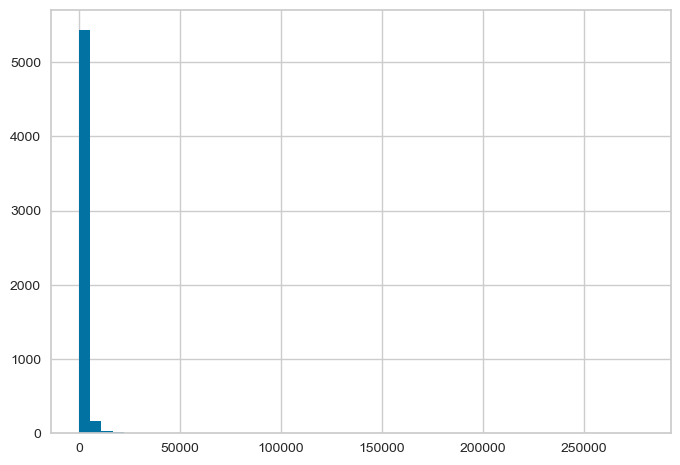

In [51]:
df_ref['gross_revenue'].hist(bins=50)

<AxesSubplot: >

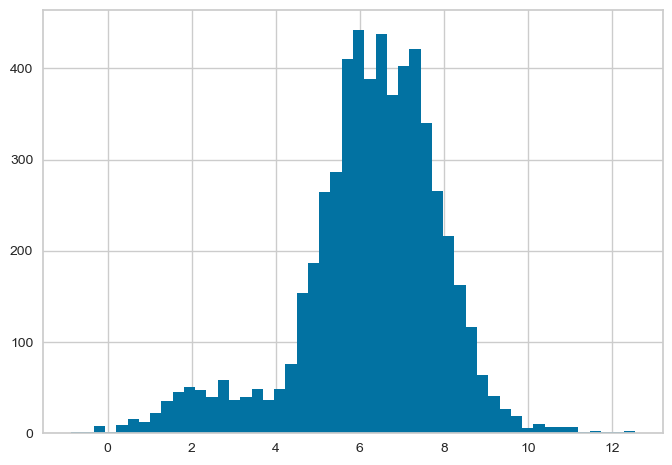

In [52]:
np.log(df_ref['gross_revenue']).hist(bins=50)

-gross_revenue - log

-recency_days - sqrt

-qty_invoices - none

-qty_items_purchased - log

-products_variety - cbrt

-avg_ticket - log

-frequency_days - sqrt if evaluate removing '1 day'

-total_return - none

-avg_basket_size - cbrt

-avg_unit_price - log

-diff_avg_prices - none

-diff_avg_qty - none

In [53]:
# reshaping distributions
df_ref['gross_revenue'] = np.log(df_ref['gross_revenue'])
df_ref['recency_days'] = np.sqrt(df_ref['recency_days'])
df_ref['qty_items_purchased'] = np.log(df_ref['qty_items_purchased'])
df_ref['products_variety'] = np.cbrt(df_ref['products_variety'])
df_ref['avg_ticket'] = np.log(df_ref['avg_ticket'])
df_ref['frequency_days'] = np.sqrt(df_ref['frequency_days'])
df_ref['avg_basket_size'] = np.cbrt(df_ref['avg_basket_size'])
df_ref['avg_variety_basket'] = np.cbrt(df_ref['avg_variety_basket'])
df_ref['avg_unit_price'] = np.log(df_ref['avg_unit_price'])

In [54]:
#dropping records w/ NAs generated in feature engineering => will be investigated later
df_ref = df_ref.dropna()

In [55]:
df_ref.isna().sum()

customer_id            0
gross_revenue          0
recency_days           0
qty_invoices           0
qty_items_purchased    0
products_variety       0
avg_ticket             0
frequency_days         0
total_return           0
avg_basket_size        0
avg_variety_basket     0
avg_unit_price         0
dtype: int64

#### Feature Ideas
- Sazonality (moving average)
- LTV (Average customer lifespan x Customer Value = Avg Purchase Value x Avg Purchase Frequency)

# 5. Exploratory Data Analysis

In [56]:
#df5 = df4.copy()
df5 = df_ref.copy()

In [57]:
# profile = ProfileReport(df5)
# profile.to_file('EDA_v4.html')

## 5.1 Univariate Analysis

In [58]:
df5[df5['gross_revenue'] > 5500].sort_values('gross_revenue', ascending=False).head(20)

,customer_id,gross_revenue,recency_days,qty_invoices,qty_items_purchased,products_variety,avg_ticket,frequency_days,total_return,avg_basket_size,avg_variety_basket,avg_unit_price


In [59]:
df5[df5['qty_invoices'] > 11].sort_values('qty_invoices', ascending=False).head(20)

,customer_id,gross_revenue,recency_days,qty_invoices,qty_items_purchased,products_variety,avg_ticket,frequency_days,total_return,avg_basket_size,avg_variety_basket,avg_unit_price
47,12748,10.383359,0.000000,206.0,10.146865,12.087326,1.953904,1.347418,1535.0,4.984483,2.046639,0.865248
66,14911,11.822435,1.000000,198.0,11.292017,12.130520,3.193880,1.372530,3331.0,7.398298,2.081250,1.204315
68,17841,10.620540,1.000000,124.0,10.045551,10.975151,1.653801,1.734377,203.0,5.707360,2.200915,0.928429
277,13089,10.982336,1.414214,97.0,10.343998,8.599748,3.476844,1.947772,283.0,6.842107,1.871666,1.007161
8,15311,11.014817,0.000000,91.0,10.550434,8.276773,3.240381,2.027286,474.0,7.487174,1.840125,0.918702
96,14606,9.393216,1.000000,90.0,8.734560,9.344657,1.493321,2.035791,245.0,4.102446,2.085207,1.029507
182,12971,9.322768,1.732051,86.0,9.136586,4.546836,3.602456,2.074205,85.0,4.762374,1.030093,0.837389
1014,14646,12.539462,1.000000,72.0,12.190167,8.874810,4.909000,2.217356,288.0,13.982878,2.133282,0.873260
12,16029,11.196598,6.164414,62.0,10.601796,3.503398,5.711801,2.327951,8004.0,8.655723,0.885168,0.877610
19,13408,10.244131,1.000000,62.0,9.694740,6.162240,4.074520,2.452780,104.0,6.397252,1.556950,0.891629


In [60]:
df5[df5['qty_items_purchased'] > 3000].sort_values('qty_items_purchased', ascending=False).head(20)

,customer_id,gross_revenue,recency_days,qty_invoices,qty_items_purchased,products_variety,avg_ticket,frequency_days,total_return,avg_basket_size,avg_variety_basket,avg_unit_price


In [61]:
df5[df5['products_variety'] > 241].sort_values('products_variety', ascending=False).head(20)

,customer_id,gross_revenue,recency_days,qty_invoices,qty_items_purchased,products_variety,avg_ticket,frequency_days,total_return,avg_basket_size,avg_variety_basket,avg_unit_price


In [62]:
df5[df5['avg_ticket'] > 80].sort_values('avg_ticket', ascending=False).head(20)

,customer_id,gross_revenue,recency_days,qty_invoices,qty_items_purchased,products_variety,avg_ticket,frequency_days,total_return,avg_basket_size,avg_variety_basket,avg_unit_price


<AxesSubplot: >

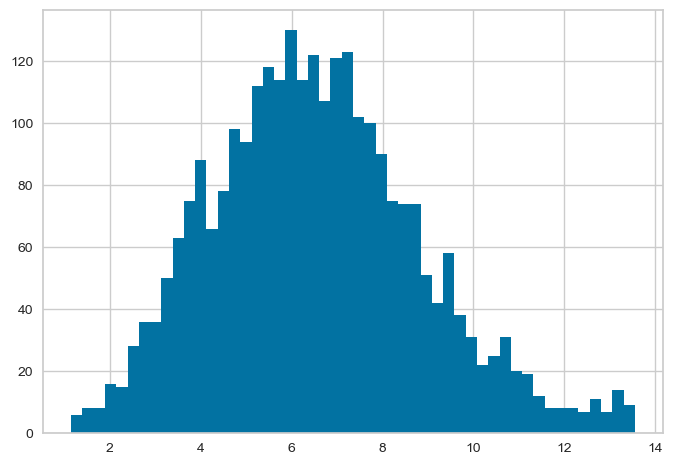

In [63]:
df5[df5['frequency_days']>1]['frequency_days'].hist(bins=50)

In [64]:
df5[df5['total_return'] > 40].sort_values('total_return', ascending=False).head(20)

,customer_id,gross_revenue,recency_days,qty_invoices,qty_items_purchased,products_variety,avg_ticket,frequency_days,total_return,avg_basket_size,avg_variety_basket,avg_unit_price
1259,15749,10.704015,15.329710,3.0,9.799681,1.709976,8.401430,5.715476,9014.0,18.180623,1.185631,1.113172
12,16029,11.196598,6.164414,62.0,10.601796,3.503398,5.711801,2.327951,8004.0,8.655723,0.885168,0.877610
967,12931,10.646756,4.582576,15.0,10.240103,3.036589,6.240037,4.739902,4427.0,12.313351,1.231277,0.531632
2539,14607,9.617238,3.872983,12.0,9.281172,3.332222,5.260529,4.536886,3768.0,9.635186,1.455482,0.770880
66,14911,11.822435,1.000000,198.0,11.292017,12.130520,3.193880,1.372530,3331.0,7.398298,2.081250,1.204315
248,17949,10.968724,1.000000,44.0,10.323841,3.036589,6.734617,2.903759,2878.0,8.845279,0.860139,1.214354
907,15482,9.307010,3.872983,11.0,8.520986,3.556893,4.732299,5.592202,2022.0,7.698536,1.599337,1.240672
264,15769,10.937610,2.645751,26.0,10.297959,2.962496,6.070075,3.746794,2012.0,10.450197,1.000000,0.718215
2335,12901,9.778748,2.828427,28.0,10.046505,3.107233,5.025158,3.064777,1776.0,9.375503,1.023264,0.382796
247,16013,10.522197,1.732051,47.0,9.650915,3.107233,5.587723,2.801975,1594.0,6.914282,0.861009,1.030929


In [65]:
# bad users - purchased 1x and returned all qty 
list(df5[df5['qty_items_purchased'] == df5['total_return']]['customer_id'])

[19026,
 19067,
 19068,
 19189,
 19211,
 19215,
 19228,
 19233,
 19242,
 19252,
 19271,
 19276,
 19278,
 19280,
 19300,
 19301,
 19313,
 19332,
 19340,
 19352,
 19356,
 19391,
 19403,
 19413,
 19468,
 19551,
 19615,
 19616,
 19653,
 19659,
 19660,
 19669,
 19685,
 19700,
 19727,
 19730,
 19733,
 19750,
 19778,
 19786,
 19803,
 19804,
 19848,
 19854,
 19860,
 19902,
 19904,
 19905,
 20001,
 20091,
 20141,
 17956,
 20244,
 20309,
 20474,
 20516,
 20524,
 20526,
 20576,
 20624,
 20631,
 20687,
 20768,
 20781,
 20824,
 20834,
 20907,
 20919,
 16257,
 20997,
 21017,
 21040,
 21044,
 21095,
 21097,
 21165,
 21182,
 21197,
 21228,
 21244,
 21280,
 21291,
 21347,
 21390,
 21467,
 21482,
 21496,
 21519,
 21538,
 21553,
 21597,
 21616,
 21646,
 21893,
 21900,
 21908,
 21913,
 22041,
 22059,
 22060,
 22075,
 22080,
 22180,
 22182,
 22279,
 22282,
 22289,
 22316,
 22321,
 22477,
 22486,
 22567,
 22568,
 22643]

In [66]:
df5[df5['avg_basket_size'] > 735].sort_values('avg_basket_size', ascending=False).head(20)

,customer_id,gross_revenue,recency_days,qty_invoices,qty_items_purchased,products_variety,avg_ticket,frequency_days,total_return,avg_basket_size,avg_variety_basket,avg_unit_price


In [67]:
df5[df5['avg_variety_basket'] > 175].sort_values('avg_variety_basket', ascending=False).head(20)

,customer_id,gross_revenue,recency_days,qty_invoices,qty_items_purchased,products_variety,avg_ticket,frequency_days,total_return,avg_basket_size,avg_variety_basket,avg_unit_price


## To investigate:
- gross_revenue => 95th percentile = 7169.562 / Max: 279138.02 -> Many people spending little, a couple spending a lot (investigate if these 'outliers' are good to solve our business problem)
- recency_days => distribution seems ok 
- qty_invoices => follow same pattern of gross_revenue => see if business intrinsec behaviour
- qty_items_purchased => follow same pattern of gross_revenue => see if business intrinsec behaviour
- products_variety => follow same pattern of gross_revenue => see if business intrinsec behaviour
- avg_ticket => follow same pattern of gross_revenue => see if business intrinsec behaviour
- frequency_days => distribution seems ok (many customers made only 1 purchase, frequency = 1)
- total_return => follow same pattern of gross_revenue => see if business intrinsec behaviour
- avg_basket_size => follow same pattern of gross_revenue => see if business intrinsec behaviour
- avg_variety_size => less skewed but still following gross_revenue pattern => see if business intrinsec behaviour 

**Conclusion:** Checked extreme cases and seems that these extreme values (despite normal behaviour) are distorting statistics/distribution. 

**Actions:**
- We will keep the values since they are part of business, except 'bad user list' which was removed (section 3.3)

## 5.2 Bivariate Analysis

In [68]:
# df52 = df5.drop('customer_id',axis=1)
# plt.figure(figsize=(26,12))
# sns.pairplot(df52);

## To investigate:

- frequency_day has low variance

- avg_ticket has low variance

**Actions:**
Evaluate it on feature selection

## 5.3 Data Space Investigation

In [69]:
# df53 = df5.drop(columns='customer_id',axis=1)

# #we will pick
cols_selected = [
                 'gross_revenue',
                 'recency_days', 
                 'qty_invoices',
                 'products_variety',
                 'avg_ticket',
                 'frequency_days',
                 'total_return',
                 'avg_basket_size',
                 'avg_unit_price'
]

df53 = df5[cols_selected]

In [70]:
#scaling data to change to another space
mms = MinMaxScaler()

for col in df53.columns:
    df53[col] = mms.fit_transform(df53[[col]])

In [71]:
X_emb = df53.copy()

### 5.3.1 PCA

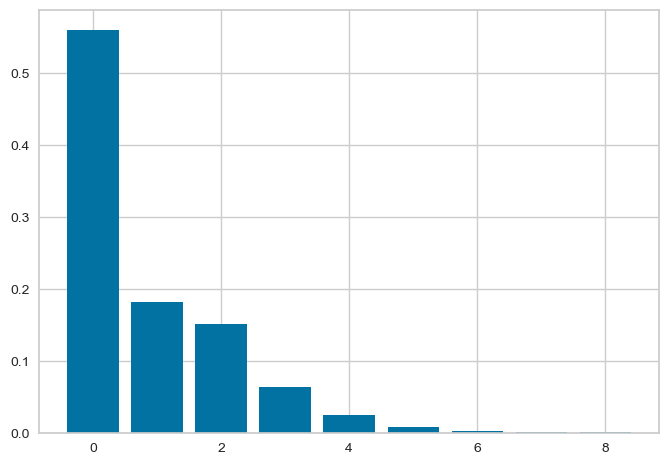

In [72]:
pca = PCA(n_components=X_emb.shape[1])
principal_components = pca.fit_transform(X_emb)

features = range(pca.n_components)

plt.bar(features, pca.explained_variance_ratio_);

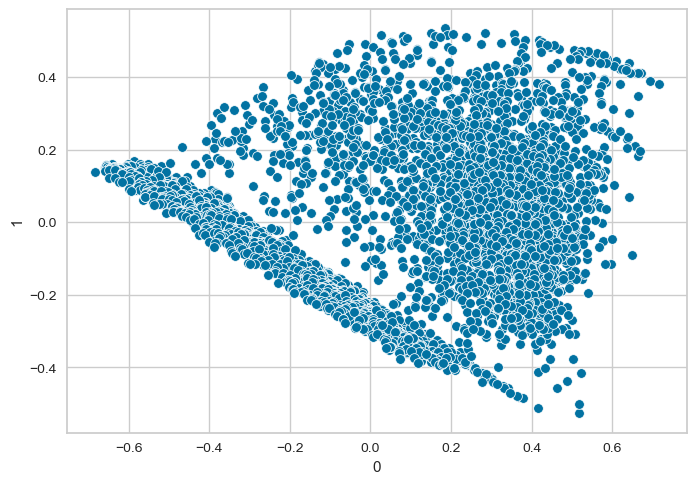

In [73]:
df_pca = pd.DataFrame(principal_components)
sns.scatterplot(x=0,y=1, data=df_pca);

### 5.3.2 UMAP

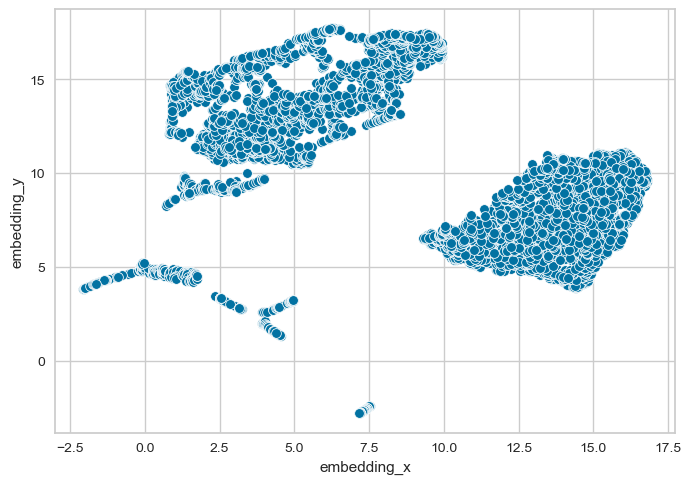

In [74]:
#instantiate a space reducer
reducer = umap.UMAP(random_state=SEED)

#create a embedding space
embedding = reducer.fit_transform(X_emb)

df_umap = pd.DataFrame(embedding, columns=['embedding_x','embedding_y'])


#plot high dimensional space into 2d 
sns.scatterplot(x='embedding_x', y='embedding_y', data=df_umap);

### 5.3.3 t-SNE

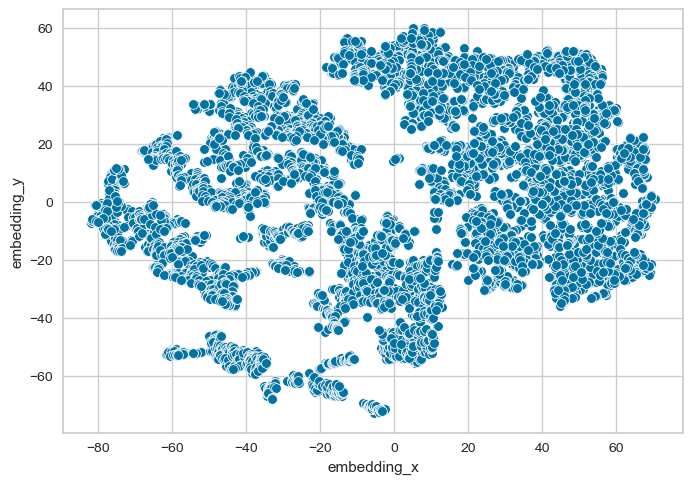

In [75]:
#instantiate a space reducer
reducer = TSNE(n_components=2, random_state=SEED, n_jobs=-1)

#create a embedding space
embedding = reducer.fit_transform(X_emb)

df_tsne = pd.DataFrame(embedding, columns=['embedding_x','embedding_y'])

#plot high dimensional space into 2d 
sns.scatterplot(x='embedding_x', y='embedding_y', data=df_tsne);

### 5.3.4 Tree Based Embedding

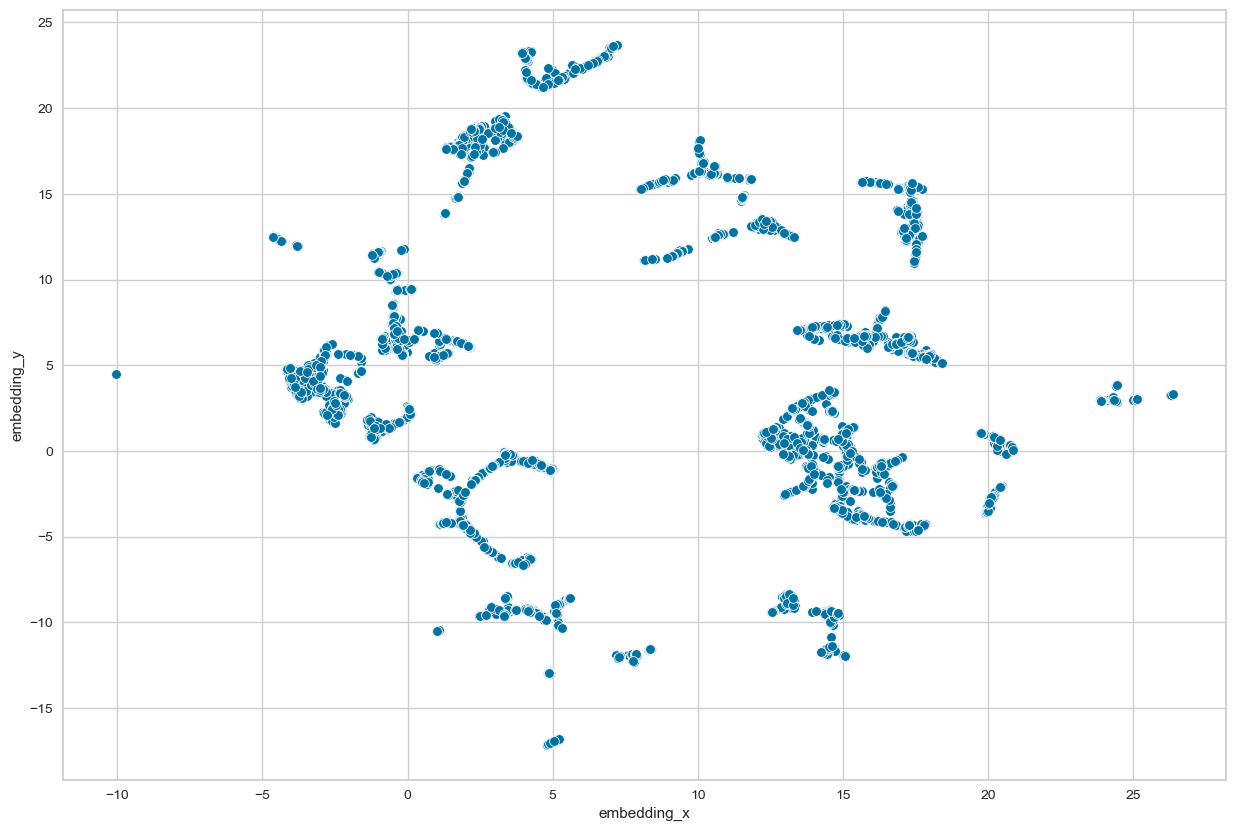

In [76]:
# X_emb = df53.drop(columns='gross_revenue', axis=1)
# y = df53['gross_revenue'] 

cols_selected_tree = [
                      'recency_days', 
                      'qty_invoices',
                      'products_variety',
                      'avg_ticket',
                      'frequency_days',
                      'total_return',
                      'avg_basket_size',
                      'avg_unit_price'
                     ]


X_emb = df5[cols_selected_tree]
y = df5['gross_revenue']

# model definition
rf = RandomForestRegressor(n_estimators=300, random_state=SEED)

# model training
rf.fit(X_emb,y)

# dataframe leaves - tree-based embedding
df_leaf = pd.DataFrame(rf.apply(X_emb))

#instantiate a space reducer
reducer = umap.UMAP(random_state=SEED)

#create a embedding space
embedding_rf = reducer.fit_transform(df_leaf)

df_tree = pd.DataFrame(embedding_rf, columns=['embedding_x','embedding_y'])


#plot high dimensional space into 2d 
plt.figure(figsize=(15,10))
sns.scatterplot(x='embedding_x', y='embedding_y', data=df_tree);

# 6. Data Preparation

- Padronização (Standardization) => premissa que dados vieram de uma distribuição normal -> Coloca os dados de media 0 e 1 desvio padrao (caso haja outliers = RobustScaler)
- Normalização (Rescaling) => Sem premissa de normalidade -> coloca os dados entre 0-1 (MinMaxScaler) 

- Teste de Normalidade = QQ plot
- Test KS = Kolgomorov Smirnoff (Teste Hipotese) p-value>0.5  distribuição normal / p-value<0.5 distribuição não-normal
- Distribuição normal sem outliers => StandardScaler (mean e std)
- Distrubuição normal com outliers => RobustScaler (quartis)
- Distribuição não-normal => MinMaxScaler

In [77]:
df6 = df5.copy()

In [78]:
#removing customer_id
cols = ['gross_revenue', 
        'recency_days',
        'qty_invoices',
        'qty_items_purchased',
        'products_variety', 
        'avg_ticket',
        'frequency_days',
        'total_return',
        'avg_basket_size',
        'avg_variety_basket',
        'avg_unit_price',
        'diff_avg_prices',
        'diff_avg_qty'
       ]

In [79]:
# from scipy import stats

# plt.subplots(4,4,figsize=(20,20))
# for idx,col in enumerate(cols):

#     stats.probplot(df6[col],plot=plt.subplot(4,4,idx+1));
#     plt.title('QQ Plot in Column {}'.format(col))

In [80]:
# plt.subplots(4,3,figsize=(20,20))
# for idx,col in enumerate(cols):
#     plt.subplot(4,4,idx+1)
#     sns.boxplot(df6[col])
#     plt.title('Column: {}'.format(col))

In [81]:
#scaler = MinMaxScaler() # not normal distributed parameters with extreme values => we will use MinMax
#scaler = RobustScaler()
#scaler = StandardScaler()

#cols = ['gross_revenue', 'qty_invoices', 'qty_items_purchased', 'products_variety', 'avg_ticket', 'recency_days', 'avg_recency_days', 
# #        'frequency_days', 'total_return', 'avg_basket_size', 'avg_variety_basket', 'avg_unit_price', 'diff_avg_prices', 'diff_avg_qty'] 
# # for col in cols:
# #     df6[col] = scaler.fit_transform(df6[[col]])

# #we will apply scaler one by one to inverse_transform later
# scaler_gv = MinMaxScaler()
# df6['gross_revenue'] = scaler_gv.fit_transform(df6[['gross_revenue']])

# scaler_qtinv = MinMaxScaler()
# df6['qty_invoices'] = scaler_qtinv.fit_transform(df6[['qty_invoices']])

# scaler_qtip = MinMaxScaler()
# df6['qty_items_purchased'] = scaler_qtip.fit_transform(df6[['qty_items_purchased']])

# scaler_pv = MinMaxScaler()
# df6['products_variety'] = scaler_pv.fit_transform(df6[['products_variety']])

# scaler_avgtkt = MinMaxScaler()
# df6['avg_ticket'] = scaler_avgtkt.fit_transform(df6[['avg_ticket']])

# scaler_rd = MinMaxScaler()
# df6['recency_days'] = scaler_rd.fit_transform(df6[['recency_days']])

# scaler_fd = MinMaxScaler()
# df6['frequency_days'] = scaler_fd.fit_transform(df6[['frequency_days']])

# scaler_tr = MinMaxScaler()
# df6['total_return'] = scaler_tr.fit_transform(df6[['total_return']])

# scaler_avgbs = MinMaxScaler()
# df6['avg_basket_size'] = scaler_avgbs.fit_transform(df6[['avg_basket_size']])

# scaler_avgvar = MinMaxScaler()
# df6['avg_variety_basket'] = scaler_avgvar.fit_transform(df6[['avg_variety_basket']])

# scaler_avg_prices = MinMaxScaler()
# df6['avg_unit_price'] = scaler_avg_prices.fit_transform(df6[['avg_unit_price']])

# scaler_diff_prices = MinMaxScaler()
# df6['diff_avg_prices'] = scaler_diff_prices.fit_transform(df6[['diff_avg_prices']])

# scaler_diff_qty = MinMaxScaler()
# df6['diff_avg_qty'] = scaler_diff_qty.fit_transform(df6[['diff_avg_qty']])

# 7. Feature Selection

In [82]:
df7 = df6.copy()

#In this cycle we will pick manually the features according to business knowledge to build clusters in the end of cycle  => we will study other techniques to non-supervised problems
#If changes here, must be changed on section 10.3 Cluster Profile

cols_selected =     [ 'gross_revenue',
                      'recency_days', 
                      'qty_invoices',
                      'products_variety',
                      'avg_ticket',
                      'frequency_days',
                      'total_return',
                      'avg_basket_size',
                      'avg_unit_price'
                     ]
#manual selection
df7 = df7[cols_selected]

# 8. HP Fine Tuning (cluster definition)

In [83]:
#X = df7.copy()      #feature space
X = df_tree.copy()   #embedding space
#X = df_tsne.copy()
#X = df_umap.copy()

## 8.1 WSS (Within Cluster Sum of Squares)

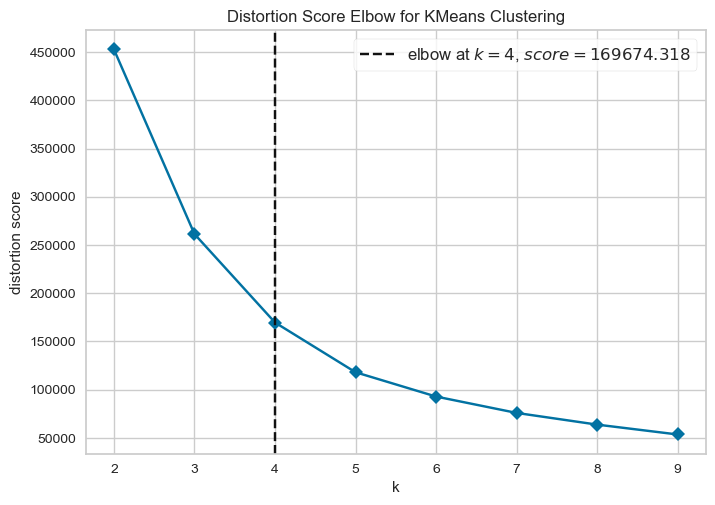

In [84]:
clusters = [2, 3, 4, 5, 6, 7, 8, 9]

kmeans = KElbowVisualizer (KMeans(), k=clusters, timings=False)
kmeans.fit(X)
kmeans.show();

## 8.2 Sillhouette Score 

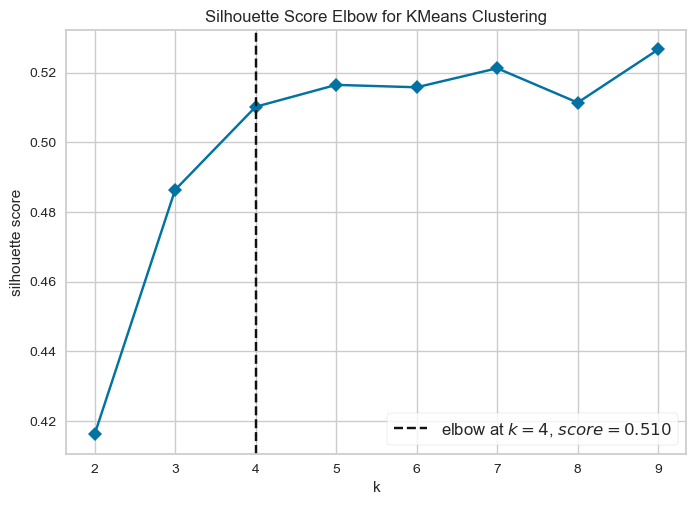

In [85]:
silhoutte = KElbowVisualizer(KMeans(), k=clusters, metric='silhouette',timings=False)
silhoutte.fit(X)
silhoutte.show();

## 8.1 Silhouette Analysis

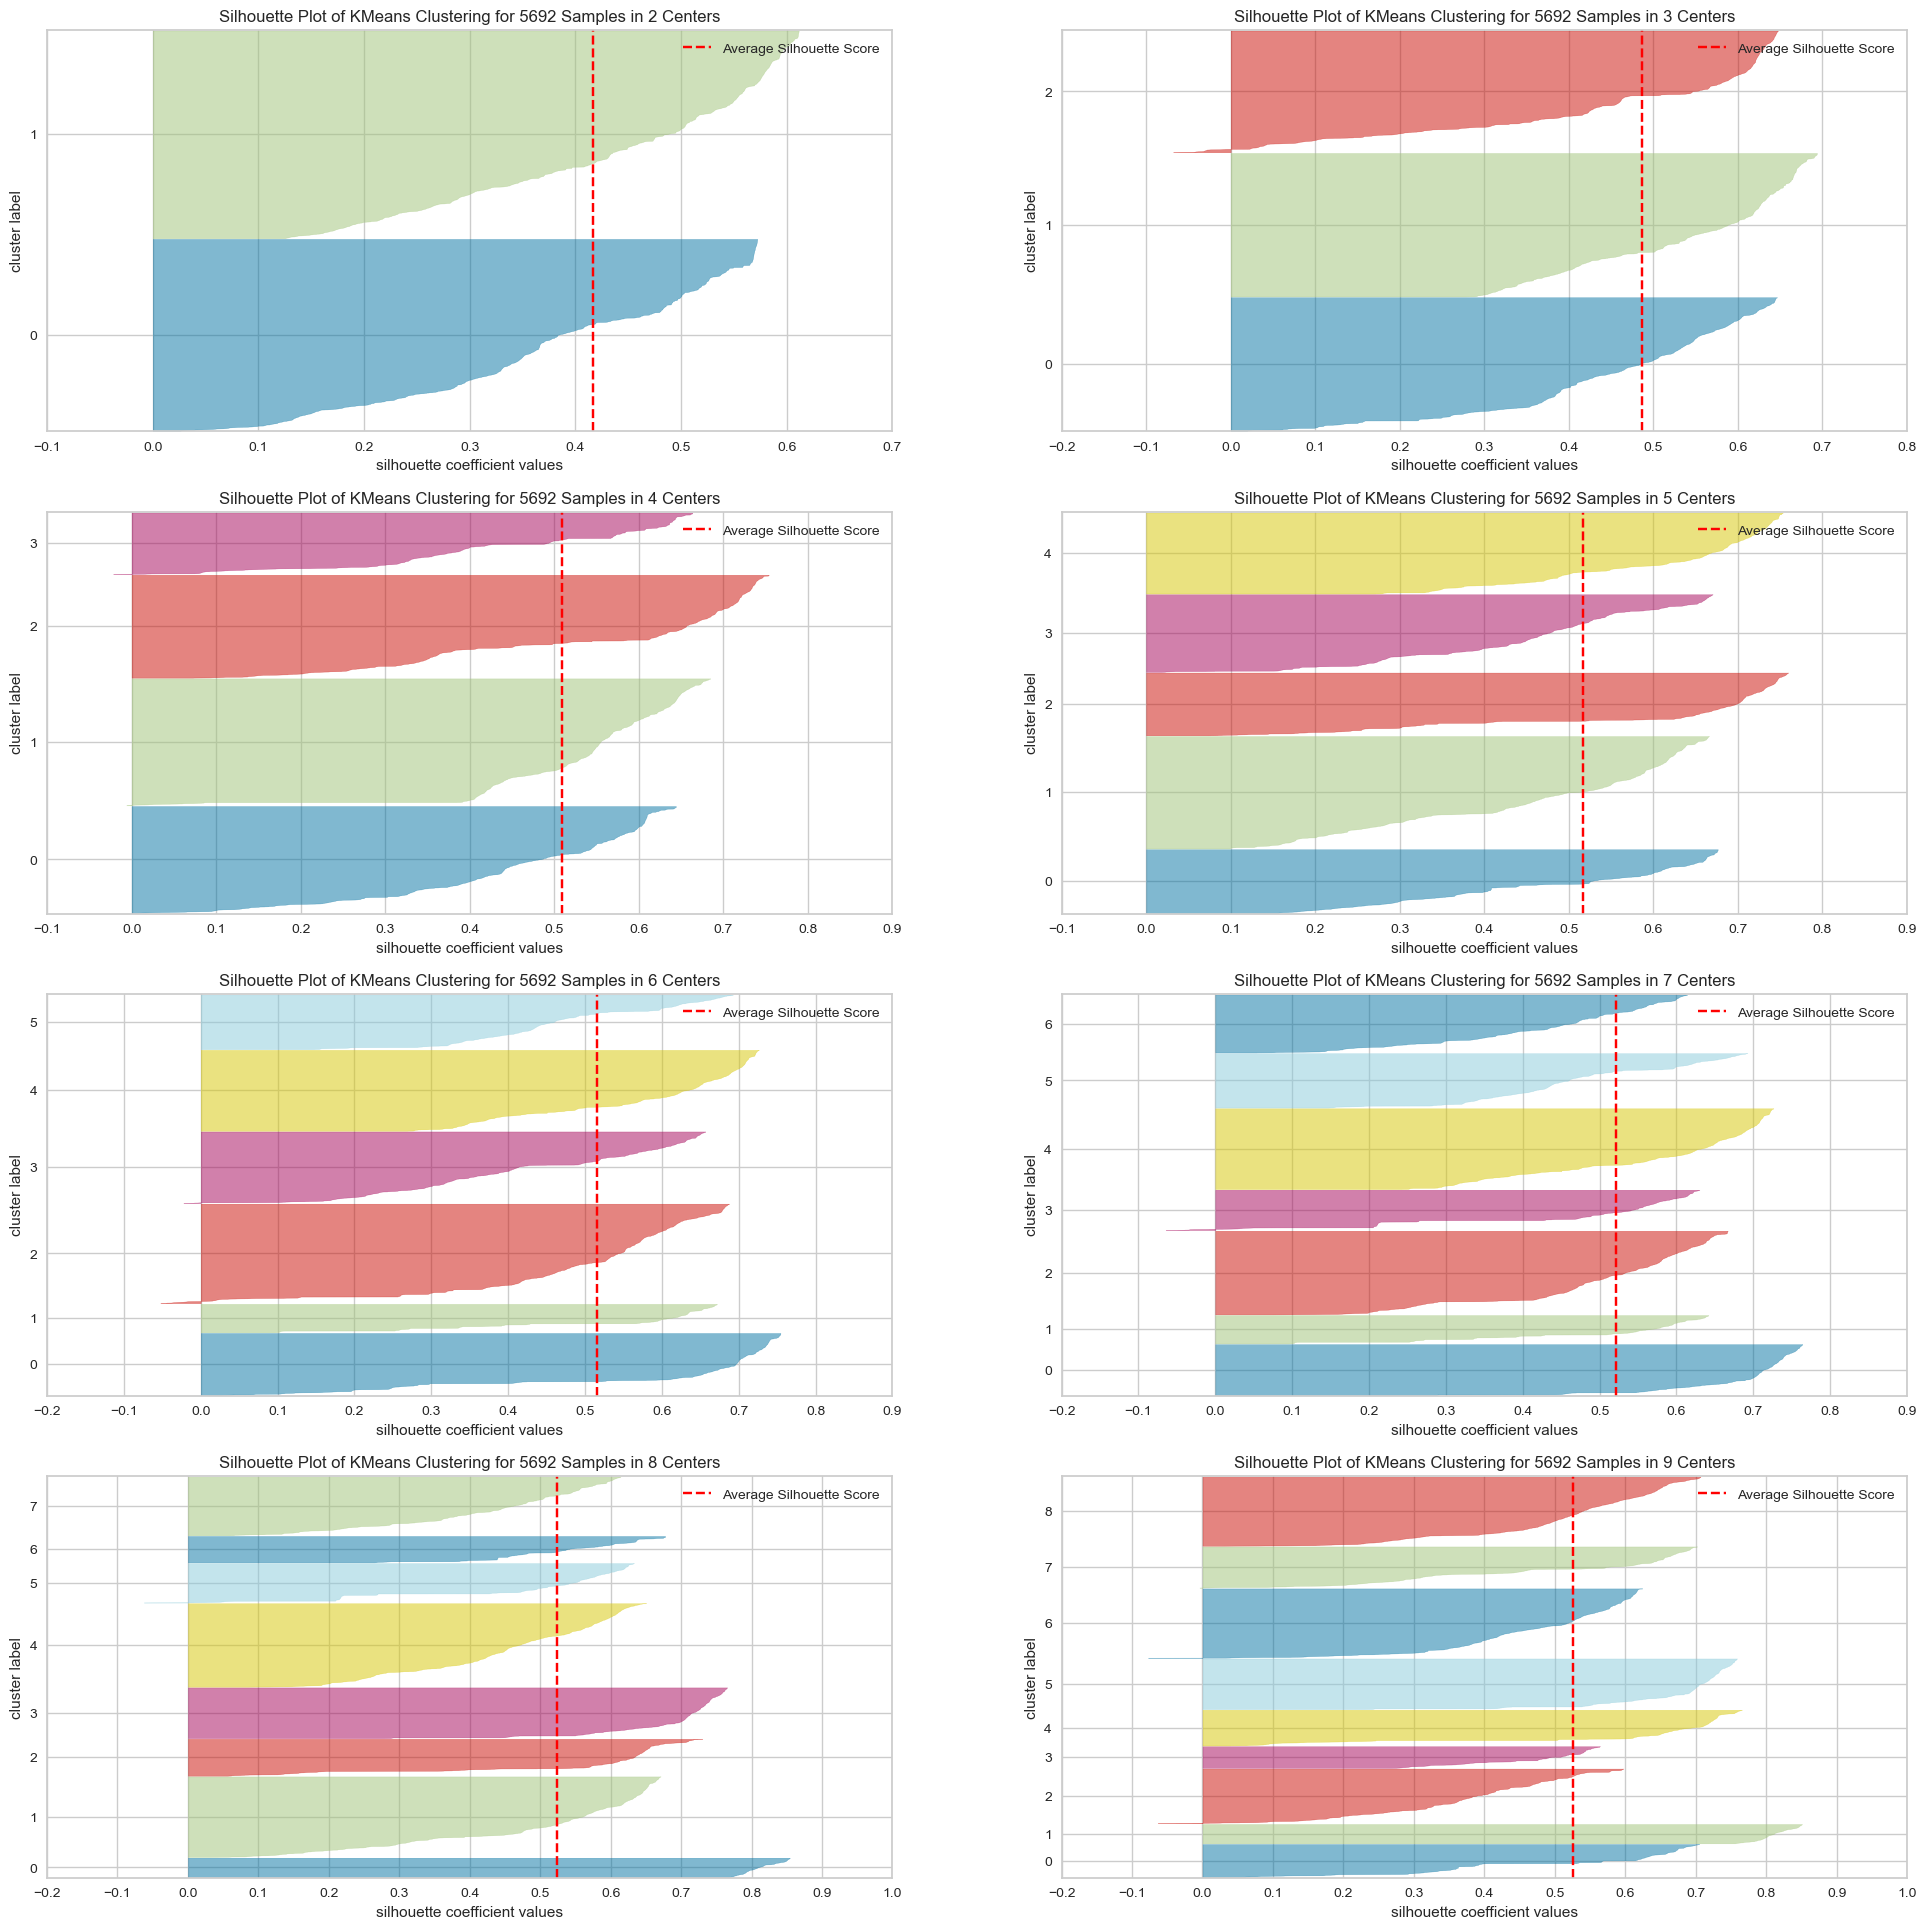

In [86]:
fig,ax = plt.subplots(4,2,figsize=(24,24))

for k in clusters:
    
    km = KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=SEED)
    
    #trick to multiplots
    q,mod = divmod(k,2)
    
    viz = SilhouetteVisualizer(km, colors='yellowbrick',ax=ax[q-1][mod] )
    viz.fit(X)
    viz.finalize()

# 9. ML Modeling

In [87]:
clusters = np.arange(2,25,1) #embbeding space
#clusters = [2,3,4,5,6,7,8,9]

## 9.1 K-Means

In [88]:
# kmeans_sil_list=[]

# for k in clusters:

#     #model definition
#     kmeans = KMeans(init='k-means++', n_clusters=k, n_init=150, max_iter=50)

#     #model training
#     kmeans.fit(X)

#     #clustering
#     labels = kmeans.predict(X)

#     #performance
#     sil_score = metrics.silhouette_score(X, labels, metric='euclidean')
#     kmeans_sil_list.append(sil_score)

In [89]:
# plt.plot(clusters, kmeans_sil_list)
# plt.xlabel('K Clusters')
# plt.ylabel('Silhouette Score')
# plt.title('KMeans Silhouette Score by K Clusters');

## 9.2 Gaussian Mixture Model

In [90]:
# gmm_sil_list = []

# for k in clusters:

#     #model definition
#     gmm = GaussianMixture(init_params='k-means++',n_components=k,n_init=150, max_iter=50)

#     #model training
#     gmm.fit(X)

#     #model clustering

#     labels = gmm.predict(X)

#     #model performance

#     sil_score = metrics.silhouette_score(X, labels, metric='euclidean')
#     gmm_sil_list.append(sil_score)


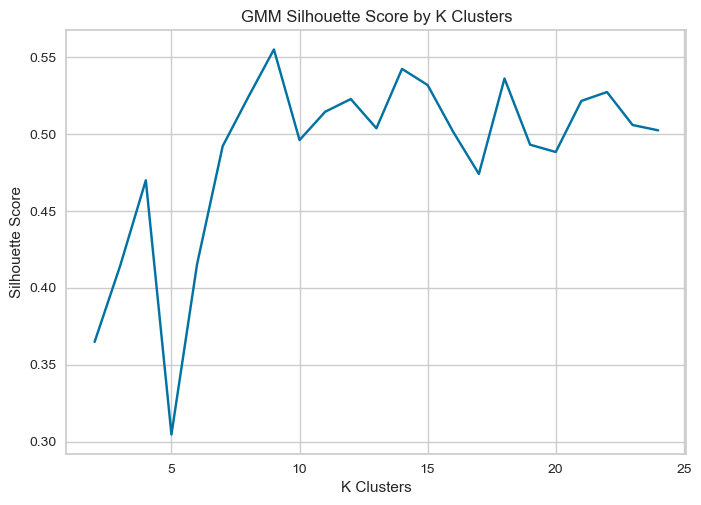

In [91]:
# plt.plot(clusters, gmm_sil_list)
# plt.xlabel('K Clusters')
# plt.ylabel('Silhouette Score')
# plt.title('GMM Silhouette Score by K Clusters');

## 9.3 Hierarchical Clustering

In [92]:
# hc_sil_list = []

# for k in clusters:
#     # model definition and training
#     h_cluster = hierarchy.linkage(X, 'ward')

#     # model predict
#     labels = hierarchy.fcluster(h_cluster, k, criterion='maxclust')

#     # model performance
#     sil_score = metrics.silhouette_score(X, labels, metric='euclidean')
#     hc_sil_list.append(sil_score)

In [93]:
# plt.plot(clusters, hc_sil_list)
# plt.xlabel('K Clusters')
# plt.ylabel('Silhouette Score')
# plt.title('H-Clustering Silhouette Score by K Clusters');

## 9.4 DBSCAN

In [94]:
# # Defining an objective function to be optimized
# def bayesian_opt_objective(trial):
#     eps = trial.suggest_float('eps', 5, 12, step=0.5)
#     min_samples = trial.suggest_int('min_samples', 2, 50, step=2)
    
#     # Model definition
#     dbscan_model = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
    
#     # Training the model and predicting
#     labels = dbscan_model.fit_predict(X)

#     # Performance
#     sil = metrics.silhouette_score(X, labels, metric='euclidean')

#     return sil 

# study = optuna.create_study(direction='maximize') # maximizing the precision at k
# study.optimize(bayesian_opt_objective, n_trials=100); # optimizing the defined function and setting the number of trials
# trial = study.best_trial

# print(f'Best Silhouette Score = {trial.value} with K = {len(set(labels))}')
# print(f'Best Hyperparameters = {trial.params}')

## 9.5 Results

In [95]:
# Silhouette Score Matrix to many clusters - FEATURE SPACE

# df_results = pd.DataFrame({'KMeans':kmeans_sil_list, 
#                            'GMM': gmm_sil_list, 
#                            'H-Clustering':hc_sil_list,
#                            }).T
# df_results.columns = clusters

# df_results.style.highlight_max(color='lightgreen',axis=1)

### 9.5.2 SS - Embbeding

In [96]:
# Silhouette Score Matrix to many clusters - TREE BASED

# df_results = pd.DataFrame({'KMeans':kmeans_sil_list, 
#                            'GMM': gmm_sil_list, 
#                            'H-Clustering':hc_sil_list,
#                            }).T
# df_results.columns = clusters

# df_results.style.highlight_max(color='lightgreen',axis=1)

In [97]:
# # Silhouette Score Matrix to many clusters - TSNE

# df_results = pd.DataFrame({'KMeans':kmeans_sil_list, 
#                            'GMM': gmm_sil_list, 
#                            'H-Clustering':hc_sil_list,
#                            }).T
# df_results.columns = clusters

# df_results.style.highlight_max(color='lightgreen',axis=1)

In [98]:
# # Silhouette Score Matrix to many clusters - UMAP

# df_results = pd.DataFrame({'KMeans':kmeans_sil_list, 
#                            'GMM': gmm_sil_list, 
#                            'H-Clustering':hc_sil_list,
#                            }).T
# df_results.columns = clusters

# df_results.style.highlight_max(color='lightgreen',axis=1)

## 9.6 Final Model

In [99]:
# cluster number definition - here is important to consider not only SS but business application (i.e, we can't pick high k which we couldnt explain customer behaviour)
k = 9 #embedding space

#model definition
gmm = GaussianMixture(init_params='k-means++',n_components=k,n_init=150, max_iter=50)

#model training
labels = gmm.fit_predict(X)

#model performance
sil_score = metrics.silhouette_score(X, labels, metric='euclidean')
print('Final Sillhouete Score: {:.2f}'.format(sil_score))

Final Sillhouete Score: 0.52


In [100]:
# #Defining the model
# dbscan_model = DBSCAN(eps=0.81, min_samples=35, n_jobs=-1)
# # Training the model and predicting
# labels = dbscan_model.fit_predict(X)
# # Performance
# sil = metrics.silhouette_score(X, labels, metric='euclidean')
# print(sil)

# 10. Cluster Analysis

In [101]:
df_viz = X.copy()

#cluster attribution
df_viz['cluster'] = labels

## 10.1 Visual Inspection

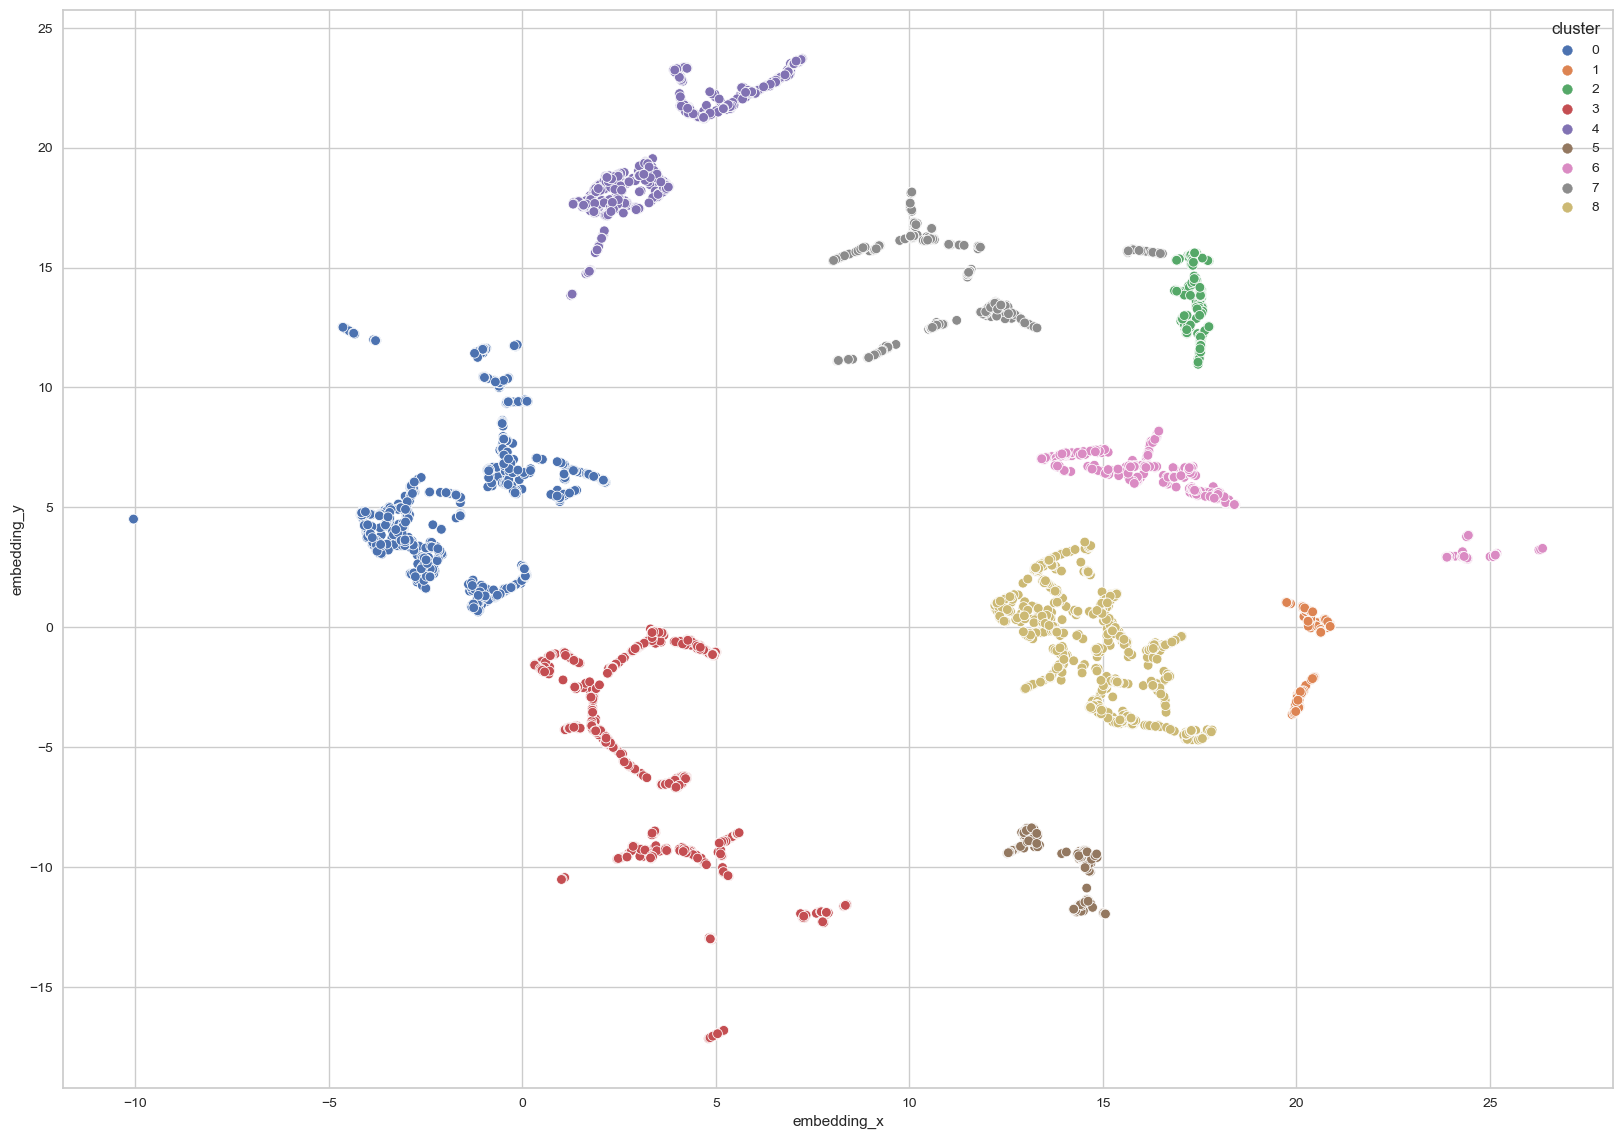

In [102]:
#plot high dimensional space into 2d 
plt.figure(figsize=(20,14))

# #instantiate a space reducer
# reducer = umap.UMAP(random_state=SEED)

# #create a embedding space
# embedding = reducer.fit_transform(X)

# df_viz['embedding_x'] = embedding[:,0]
# df_viz['embedding_y'] = embedding[:,1]
# # #df_viz = pd.DataFrame(embedding, columns=['embedding_x','embedding_y'])

#plot high dimensional space into 2d 
sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster', palette='deep', data=df_viz);

## 10.3 Cluster Profile

In [103]:
df10 = df5[cols_selected_tree]
df10[['gross_revenue','customer_id']] = df5[['gross_revenue','customer_id']]
df10['cluster'] = labels

In [104]:
# shaping back distributions
df10['gross_revenue'] = np.exp(df_ref['gross_revenue'])
df10['recency_days'] = (df_ref['recency_days'])**2
df10['qty_items_purchased'] = np.exp(df_ref['qty_items_purchased'])
df10['products_variety'] = (df_ref['products_variety'])**3
df10['avg_ticket'] = np.exp(df_ref['avg_ticket'])
df10['frequency_days'] = (df_ref['frequency_days'])**2
df10['avg_basket_size'] = (df_ref['avg_basket_size'])**3
df10['avg_variety_basket'] = (df_ref['avg_variety_basket'])**3
df10['avg_unit_price'] = np.exp(df_ref['avg_unit_price'])

In [105]:
#Number of Customers
df_cluster = df10[['customer_id', 'cluster']].groupby('cluster').count().reset_index().rename(columns={'customer_id':'qty_customers'})
df_cluster['perc_customers'] = (df_cluster['qty_customers'] / df_cluster['qty_customers'].sum())*100

# Average Gross Revenue
df_gr = df10[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index().rename(columns={'gross_revenue':'avg_revenue'})
df_cluster = pd.merge(df_cluster,df_gr, on='cluster', how='inner')
 
#Average Recency
df_rec = df10[['recency_days', 'cluster']].groupby('cluster').mean().reset_index().rename(columns={'recency_days':'avg_recency'})
df_cluster = pd.merge(df_cluster,df_rec, on='cluster', how='inner')

# Average Products Variety
df_var = df10[['products_variety', 'cluster']].groupby('cluster').mean().reset_index().rename(columns={'products_variety':'avg_variety'})
df_cluster = pd.merge(df_cluster,df_var, on='cluster', how='inner')

# Average Frequency
df_fre = df10[['frequency_days', 'cluster']].groupby('cluster').mean().reset_index().rename(columns={'frequency_days':'avg_frequency'})
df_cluster = pd.merge(df_cluster,df_fre, on='cluster', how='inner') 

#Average Total Return
df_ret = df10[['total_return', 'cluster']].groupby('cluster').mean().reset_index().rename(columns={'total_return':'avg_returns'})
df_cluster = pd.merge(df_cluster,df_ret, on='cluster', how='inner') 

#Average Price Unit
df_price = df10[['avg_unit_price', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster,df_price, on='cluster', how='inner') 

#Average Basket Size
df_basket = df10[['avg_basket_size', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster,df_basket, on='cluster', how='inner') 

#Average Ticket
df_ticket = df10[['avg_ticket', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster,df_ticket, on='cluster', how='inner') 

#Qty Invoices
df_invo = df10[['qty_invoices', 'cluster']].groupby('cluster').mean().reset_index().rename(columns={'qty_invoices':'avg_invoices'})
df_cluster = pd.merge(df_cluster,df_invo, on='cluster', how='inner') 

#reordering
df_cluster = df_cluster[['cluster','qty_customers','perc_customers','avg_revenue','avg_ticket','avg_unit_price','avg_basket_size','avg_invoices','avg_variety','avg_recency','avg_frequency','avg_returns']]

df_cluster.sort_values(by='avg_revenue', ascending=False)

,cluster,qty_customers,perc_customers,avg_revenue,avg_ticket,avg_unit_price,avg_basket_size,avg_invoices,avg_variety,avg_recency,avg_frequency,avg_returns
5,5,279,4.901616,12952.705018,32.163428,2.931530,302.740437,21.189964,217.082437,13.290323,20.244986,98.347670
1,1,208,3.654252,3671.843846,13.120975,3.377779,787.056397,5.254808,298.144231,84.052885,20.822463,17.567308
2,2,305,5.358398,3149.327213,69.830982,3.411507,219.136048,6.868852,26.659016,50.118033,42.157107,97.121311
8,8,1020,17.919888,2381.905020,18.696965,3.655053,414.986675,3.608824,117.659804,92.420588,32.247183,13.527451
7,7,538,9.451862,1434.681561,68.739660,4.126128,207.226383,3.656134,39.314126,81.184015,45.154251,29.905204
6,6,541,9.504568,1065.200518,7.637876,2.989272,269.284828,2.707948,139.874307,96.595194,32.259184,2.966728
4,4,730,12.825018,644.141233,56.761125,2.500293,379.487671,1.278082,25.795890,122.927397,16.161644,7.776712
0,0,1160,20.379480,314.433267,24.251082,4.084351,97.211063,1.325862,20.400000,157.915517,20.172845,1.814655
3,3,911,16.004919,75.426564,15.951739,4.789595,29.850048,1.178924,7.670692,182.118551,3.675093,0.158068


## Clusters Reports - Based on Embedding Space - Silhouette Score = 0.55 (GMM)

### Cluster Stark (Insiders Eligible):
        - Customers Quantity: 279 customers (4.9% of total)
        - Gross Revenue: $ 12952
        - Ticket: $ 32
        - Products Price: $2.93
        - Basket Size: 302 un
        - Qty Invoices: 21 purchases
        - Products Variety: 217 products       
        - Time since last purchase: 13 days
        - Time between purchases: 20 days
        - Returns: 98 units

### Cluster Targeryen:
        - Customers Quantity: 345 customers (6% of total)
        - Gross Revenue: $ 2995
        - Ticket: $ 18
        - Products Price: $3.53
        - Basket Size: 641 un
        - Qty Invoices: 4 purchases
        - Products Variety: 204 products       
        - Time since last purchase: 89 days
        - Time between purchases: 23 days
        - Returns: 13 units

### Cluster Lannister: 
        - Customers Quantity: 350 customers (6% of total)
        - Gross Revenue: $ 2892
        - Ticket: $ 63
        - Products Price: $3.37
        - Basket Size: 209 un
        - Qty Invoices: 6 purchases
        - Products Variety: 29 products        
        - Time since last purchase: 49 days
        - Time between purchases: 43 days
        - Returns: 85 units

### Cluster Greyjoy: 
        - Customers Quantity: 987 customers (17% of total)
        - Gross Revenue: $ 2326
        - Ticket: $ 18
        - Products Price: $3.63
        - Basket Size: 393 un
        - Qty Invoices: 3 purchases
        - Products Variety: 118 products        
        - Time since last purchase: 92 days
        - Time between purchases: Every 33 
        - Returns: 14 units
        
### Cluster Baratheon:
        - Customers Quantity: 493 customers (9% of total)
        - Gross Revenue: $ 1460
        - Ticket: $ 73
        - Products Price: $4.22
        - Basket Size: 213 un
        - Qty Invoices: 3 purchases
        - Products Variety: 38 products       
        - Time since last purchase: 84 days
        - Time between purchases: 44 days
        - Returns: 32 units
        


### Cluster Tully: 
        - Customers Quantity: 437 customers (8% of total)
        - Gross Revenue: $ 1006
        - Ticket: $ 5
        - Products Price: $2.86
        - Basket Size: 281 units
        - Qty Invoices: 3 purchases
        - Products Variety: 159 products purchased       
        - Time since last purchase: 97 days
        - Time between purchases: 32 days
        - Returns: 2 units
        
### Cluster Martell: 
        - Customers Quantity: 730 customers (13% of total)
        - Gross Revenue: $ 644
        - Ticket: $ 56
        - Products Price: $2.50
        - Basket Size: 379 units
        - Qty Invoices: 2 purchases
        - Products Variety: 25 products        
        - Time since last purchase: 122 days
        - Time between purchasesequency: 18 days
        - Returns: 7 units
        
### Cluster Arryn: 
        - Customers Quantity: 1160 customers (20% of total)
        - Gross Revenue: $ 315
        - Ticket: $ 24
        - Products Price: $ 4.08
        - Basket Size: 97 units
        - Qty Invoices: 2 purchases
        - Products Variety: 20 products       
        - Time since last purchase: 157 days 
        - Time between purchasesequency: 20 days
        - Returns: 1 units
        
### Cluster Mormont: 
        - Customers Quantity: 911 customers (16% of total)
        - Gross Revenue: $ 75
        - Ticket: $ 16
        - Products Price: $ 4.79
        - Basket Size: 30 units
        - Qty Invoices: 1 purchases
        - Products Variety: 7 products        
        - Time since last purchase: 182 days 
        - Time between purchasesequency:  3 days
        - Returns: 0 units
        
<h3><b>PS: Depending on cluster centroids initialization, cluster profile and its averages can vary a little -> before deployment the model will be serialized in pickle.

# 11. Exploratory Data Analysis - Clustering  Focused 

In [106]:
df11 = df10.copy()
df11

,recency_days,qty_invoices,products_variety,avg_ticket,frequency_days,total_return,avg_basket_size,avg_unit_price,gross_revenue,customer_id,cluster,qty_items_purchased,avg_variety_basket
0,372.0,34.0,21.0,18.152222,0.058824,40.0,50.970588,3.960370,5391.21,17850,2,1733.0,0.617647
1,56.0,9.0,105.0,18.904035,35.333333,35.0,154.444444,3.926082,3232.59,13047,1,1390.0,11.666667
2,2.0,15.0,114.0,28.902500,24.800000,50.0,335.200000,2.140474,6705.38,12583,5,5028.0,7.600000
3,95.0,5.0,24.0,33.866071,55.800000,0.0,87.800000,3.996429,948.25,13748,2,439.0,4.800000
4,333.0,3.0,1.0,292.000000,13.666667,22.0,26.666667,10.950000,876.00,15100,7,80.0,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5754,1.0,1.0,634.0,8.988959,1.000000,0.0,1747.000000,4.320946,5699.00,22706,1,1747.0,634.000000
5755,0.0,1.0,730.0,9.254877,1.000000,0.0,2010.000000,4.175904,6756.06,22707,1,2010.0,730.000000
5756,0.0,1.0,56.0,54.528814,1.000000,0.0,654.000000,6.269661,3217.20,22708,7,654.0,56.000000
5757,0.0,1.0,217.0,18.206083,1.000000,0.0,731.000000,6.364378,3950.72,22709,8,731.0,217.000000


## 11.1 Mindmap Hypothesis

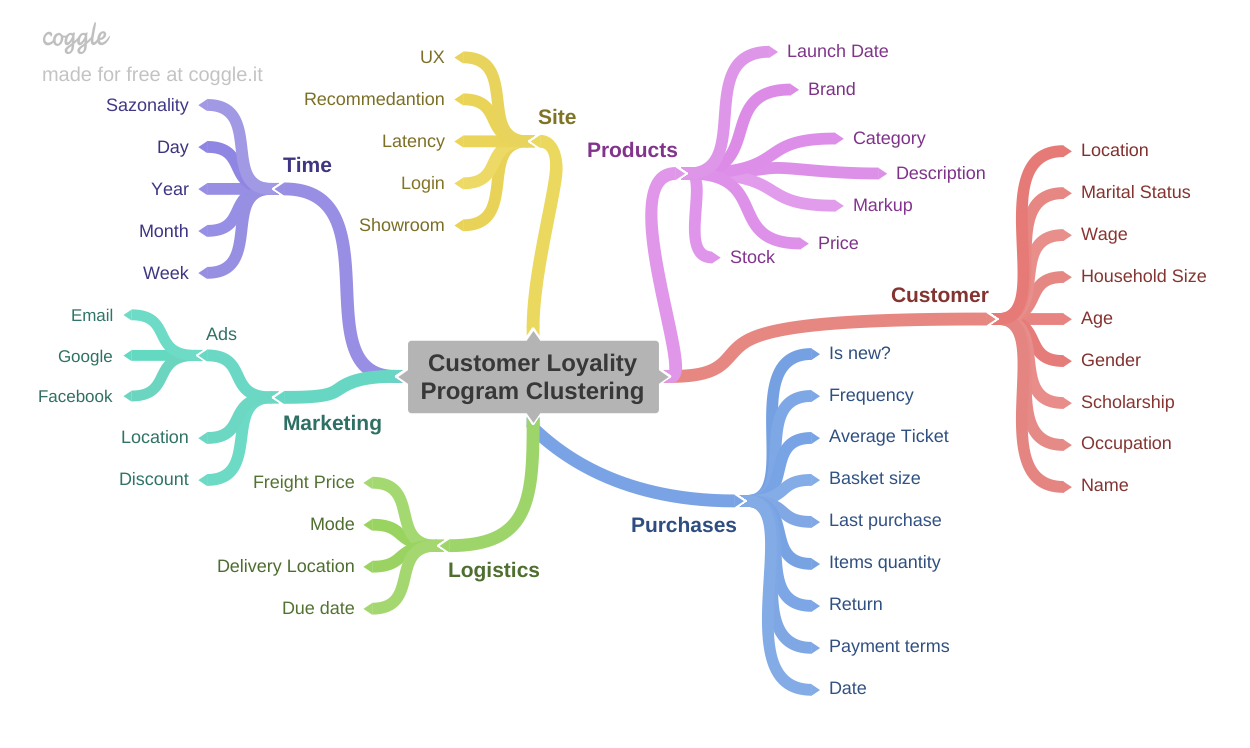

In [107]:
Image('C:/Users/marco/OneDrive/Documents/repos/ds_em_producao/insiders-loyality-program-clustering/reports/figures/Customer_Loyality_Program_Clustering.png',width=800,height=400)

## 11.2 Hipóteses de Negócio

### Purchases

H0. Os clientes do cluster Stark compram 80% das vezes com cartão de crédito

**H1. Os clientes do cluster Stark compram uma variedade média de produtos duas vezes maior que a média da base de clientes**

H2. Os clientes do cluster Stark possuem 10% de ticket médio acima do cluster Targeryen - 2nd 

H3. Os clientes do cluster Stark possuem um basket size acima de 5 produtos - 2nd 

**H4. Os clientes do cluster Stark possuem um volume de compra (faturamento) acima do 15% do total de compras**

**H5. Os clientes do cluster Stark possuem um número médio de devoluções 20% abaixo da média do restante dos clusters**

**H6. Os clientes do cluster Stark voltam a comprar em média na metade do tempo que a média geral de clientes**

### Customers

H7. 10% dos clientes do cluster Stark estão na faixa 25-35 anos

H8. 40% das localidades de entrega do cluster Stark estão dentro de um raio de 50km - 2nd 

H9. 5% dos clientes do cluster Stark recebem mais de 100k dolares por ano

H10. 90% dos clientes do cluster Stark possuem Ensino Médio

H11. 60% dos clientes do cluster Stark possuem estado civil solteiro

### Products

H12. A média dos preços dos produtos comprados pelo cluster Stark é 10% do que a mediana do restante dos clusters

H13. O peso médio dos produtos comprados pelo cluster Stark é maior que o peso médio do restante dos clusters

H14. Os clientes do cluster Stark compram 40% mais de produtos lançamentos (<90 dias) que o restante dos clusters

H15. Os clientes do cluster Stark compram produtos com maiores markups do que o restante dos clusters

### 11.2.1 Hypothesis Priorization

<h4><font color='red'>Insight and actionable? Data in-house?</h4></font>

**H1. Os clientes do cluster Stark compram uma variedade média de produtos duas vezes maior que a média do total da base de clientes**

**H4. Os clientes do cluster Stark possuem um volume de compra (faturamento) acima do 15% do total de compras**

**H5. Os clientes do cluster Stark possuem um número médio de devoluções 20% abaixo da média do restante dos clusters**

**H6. Os clientes do cluster Stark voltam a comprar em média na metade do tempo que a média geral de clientes**

- Hypothesis H2/H3/H8/H12 we have data in initial dataset, but we didnt use to clustering => we will leave to another moment if business want it
- The remaining hypothesis we don't have data and will evaluate later

## 11.3 Hypothesis Validation

**H1. Os clientes do cluster Stark compram uma variedade média de produtos duas vezes maior que a média da base de clientes**

**True** The Stark Cluster purchases 2,1x more variety

In [108]:
dif_variety = ((df11[df11['cluster']==8]['products_variety']).mean()/df11['products_variety'].mean()-1)
print('The Stark cluster purchases {:.2f} times more varied products than the whole customers database'.format(dif_variety))

The Stark cluster purchases 0.69 times more varied products than the whole customers database


**H4. Os clientes do cluster Stark possuem um volume de compra (faturamento) acima do 15% do total de compras**

**True:** The Stark cluster represents 36% of total revenue

In [109]:
dif_gr = ((df11[df11['cluster']==8]['gross_revenue']).sum()/df11['gross_revenue'].sum())
print('The Stark cluster represents {:.2f}% of total revenue'.format(dif_gr*100))

The Stark cluster represents 24.25% of total revenue


**H5. Os clientes do cluster Stark possuem um número médio de devoluções 20% abaixo da média do restante dos clusters**

**False**: Only Cluster Stark return almost 5x more, on average, than all customers returns

In [110]:
dif_ret = ((df11[df11['cluster']==8]['total_return']).mean() / (df11['total_return']).mean() )-1
print('The Stark cluster return their purchases {:.2f} times more than the whole customers database'.format(dif_ret))

The Stark cluster return their purchases -0.23 times more than the whole customers database


**H6. Os clientes do cluster Stark voltam a comprar em média na metade do tempo que a média geral de clientes**

**True**: The cluster Stark is 2x faster to back to purchase

In [111]:
dif_freq =  ((df11[df11['cluster']==8]['frequency_days']).mean() / (df11['frequency_days']).mean() )
print('The Stark cluster back to purchase {:.2f} times faster than the whole customers database'.format(1/dif_freq))

The Stark cluster back to purchase 0.74 times faster than the whole customers database


## 11.4 Hypothesis Board

## 11.5 Business Answers

- Who are the customers elegible?

In [112]:
print('The customers identified below are Insiders elegible: \n\n{}'.format(sorted(df11[df11['cluster']==3]['customer_id'].to_list())))

The customers identified below are Insiders elegible: 

[12353, 12361, 12401, 12402, 12441, 12445, 12464, 12506, 12548, 12551, 12573, 12587, 12651, 12659, 12665, 12686, 12732, 12734, 12756, 12789, 12791, 12814, 12837, 12851, 12855, 12881, 12893, 12938, 12956, 12974, 12977, 12984, 12995, 13011, 13058, 13067, 13070, 13079, 13080, 13095, 13106, 13120, 13130, 13132, 13133, 13144, 13161, 13170, 13185, 13188, 13194, 13218, 13299, 13302, 13307, 13348, 13366, 13391, 13452, 13508, 13519, 13538, 13551, 13581, 13592, 13651, 13666, 13682, 13684, 13686, 13703, 13716, 13747, 13781, 13786, 13809, 13811, 13832, 13841, 13877, 13937, 13938, 13992, 14027, 14037, 14039, 14041, 14054, 14059, 14073, 14076, 14080, 14089, 14090, 14098, 14117, 14143, 14148, 14155, 14174, 14185, 14199, 14204, 14219, 14238, 14241, 14295, 14300, 14349, 14351, 14353, 14357, 14362, 14371, 14373, 14393, 14423, 14436, 14437, 14438, 14457, 14483, 14494, 14495, 14542, 14576, 14585, 14589, 14624, 14641, 14658, 14689, 14693, 14699, 14705

- How many customers will be part of Insiders group?

In [113]:
print('Insiders Loyality Program members qty is {:.0f} - {:.2f}% of total'.format(df11[df11['cluster']==3]['customer_id'].count(),df11[df11['cluster']==3]['customer_id'].count()/df11.shape[0]*100 ))

Insiders Loyality Program members qty is 911 - 16.00% of total


- What are the main behaviour of those customers?

    - Customers Quantity: 279 customers (4.9% of total)
    - Gross Revenue: $ 12952
    - Ticket: $ 32
    - Products Price: $2.93
    - Basket Size: 302 un
    - Qty Invoices: 21 purchases
    - Products Variety: 217 products       
    - Time since last purchase: 13 days
    - Time between purchases: 20 days
    - Returns: 98 units
    
    - High gross revenue
    - Medium Ticket and Basket Size, 
    - High Products Variety
    - High number of purchases
    - Low range products price 
    - Low recency (last purchase from 'today')
    - Low time between purchases
    - High qty returned Items

- How much revenue comes from Insiders customer groups?

In [114]:
print('Total from Insiders Loyality Program is $ {:.2f} which means {:.2f}% of total'.format(df11[df11['cluster']==8]['gross_revenue'].sum(),100*(df11[df11['cluster']==8]['gross_revenue'].sum()/df11['gross_revenue'].sum()) ))

Total from Insiders Loyality Program is $ 2429543.12 which means 24.25% of total


- How much revenue is expected from Insiders next month?

    - We need Time Series here, will be delivered next cycle

- Which conditions one person must comply to be an Insider? What removes a customer from Insider group?

    - Who defines it will be the clustering model that we created. Everytime we (re)train the model, we will mark the customer in time and follow if still in loyality program or not. Here is possible to create a policy after X periods out of insiders list customer must be removed (TBD).

- What guarantees the loyality program customers are better than others?

TBD

- Which actions MKT team could take to increase revenue?

Some examples of offers/action that could be taken:
- To Stark Cluster (Insiders):

    - 1) Offer exclusive products with more added value in order to increase avg ticket and avg unit price.
    
    - 2) Offer a kind of direct consultancy/real-time assistant in order to reduce returns
    
    
- To Targeryen:
    - Offer monthly cupons in order to increase the awareness and awake the buying power since this cluster purchases have high basket size but low recency/qty invoices


- To Lannister: 
    - Offer product cross-sell in order to increase product variety since ticket, recency and frequency are ok
- Etc

# 12. Model Deployment